In [1]:
import warnings
warnings.filterwarnings("ignore")

from typing import Optional, List, Tuple, Union
from numpy.typing import NDArray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

from tsururu.strategies import StrategiesFactory
from tsururu.dataset import TSDataset
from tsururu.models import MeanMethod, NaiveMethod, SeasonalNaiveMethod, DriftMethod

In [2]:
def get_results(
    cv: int,
    regime: str,
    y_true: Optional[List[NDArray[np.floating]]] = None,
    y_pred: Optional[List[NDArray[np.floating]]] = None,
    ids: Optional[List[Union[float, str]]] = None,
) -> pd.DataFrame:
    def _get_fold_value(
        value: Optional[Union[float, NDArray[np.floating]]], idx: int
    ) -> List[Optional[Union[float, NDArray[np.floating]]]]:
        if value is None:
            return [None]
        if isinstance(value[idx], float):
            return value[idx]
        if isinstance(value[idx], np.ndarray):
            return value[idx].reshape(-1)
        raise TypeError(f"Unexpected value type. Value: {value}")

    df_res_dict = {}

    for idx_fold in range(cv):
        # Fill df_res_dict
        for name, value in [("y_true", y_true), ("y_pred", y_pred)]:
            df_res_dict[f"{name}_{idx_fold+1}"] = _get_fold_value(
                value, idx_fold
            )
        if regime != "local":
            df_res_dict[f"id_{idx_fold+1}"] = _get_fold_value(ids, idx_fold)

    # Save datasets to specified directory
    df_res = pd.DataFrame(df_res_dict)
    return df_res

def plot_baseline_results(df, horizon):
    unique_ids = sorted(df['id'].unique())
    num_ids = len(unique_ids)
    fig, axes = plt.subplots(num_ids, 1, figsize=(10, 20))

    for i, id_value in enumerate(unique_ids):
        data = df[df['id'] == id_value]
        
        axes[i].plot(data['date'], data['value'], label='y_true', color='royalblue')
        axes[i].plot(data['date'].tail(horizon), data['value'].tail(horizon), label='y_pred', color='maroon')

        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].set_title(f'TS id {id_value}')
        axes[i].grid(True)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
def calculate_score(dataframes_with_names: List[Tuple[pd.DataFrame, str]]) -> pd.DataFrame:
    def RMSE(y_true, y_pred):
        rmse = np.sqrt(MSE(y_true, y_pred)) 
        return rmse
    
    def SMAPE(y_true, y_pred):
        return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    def WAPE(y_true, y_pred):
        return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    
    all_metrics = []

    for df, model_name in dataframes_with_names:
        metrics_list = []
        
        for ts_id in df['id_1'].unique():
            ts_df = df[df['id_1'] == ts_id]
            y_true = ts_df['y_true_1'].values
            y_pred = ts_df['y_pred_1'].values
            
            ts_metrics = {
                'Model': model_name,
                'id': ts_id,
                'MAE': MAE(y_true, y_pred),
                'MSE': MSE(y_true, y_pred),
                'RMSE': RMSE(y_true, y_pred),
                'SMAPE': SMAPE(y_true, y_pred),
                'WAPE': WAPE(y_true, y_pred),
            }
            
            metrics_list.append(ts_metrics)
        
        model_metrics_df = pd.DataFrame(metrics_list)
        all_metrics.append(model_metrics_df)
    
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)
    
    return final_metrics_df

In [3]:
df_path = "datasets/global/ettm1.csv"

stat_cols_features = {
    "target": {
        "column": ["value"],
        "type": "continious",
    },
    "date": {
        "column": ["date"],
        "type": "datetime",
    },
    "id": {
        "column": ["id"],
        "type": "categorical",
    }
}

In [4]:
dataset = TSDataset(
    data=pd.read_csv(df_path),
    columns_and_features_params=stat_cols_features,
    history=100,
)

strategies_factory = StrategiesFactory()

horizon = 96
baseline_df = dataset.make_padded_test(horizon)

freq: less then Day (Hour, Min, Sec, etc); period: 900.0 seconds


## Baseline models  
This notebook will cover statistical models. First, we will examine 4 baseline models that do not require a large amount of data. Therefore, we will consider the baseline models on the last 100 observations. All materials were taken from the [book](https://otexts.com/fpp3/simple-methods.html).

### 1. Mean method

Mean method entails predicting that all future values will be the same, specifically equal to the historical data's average.


$$\hat{y}_{T+h|T} = \bar{y} = (y_{1}+\dots+y_{T})/T$$

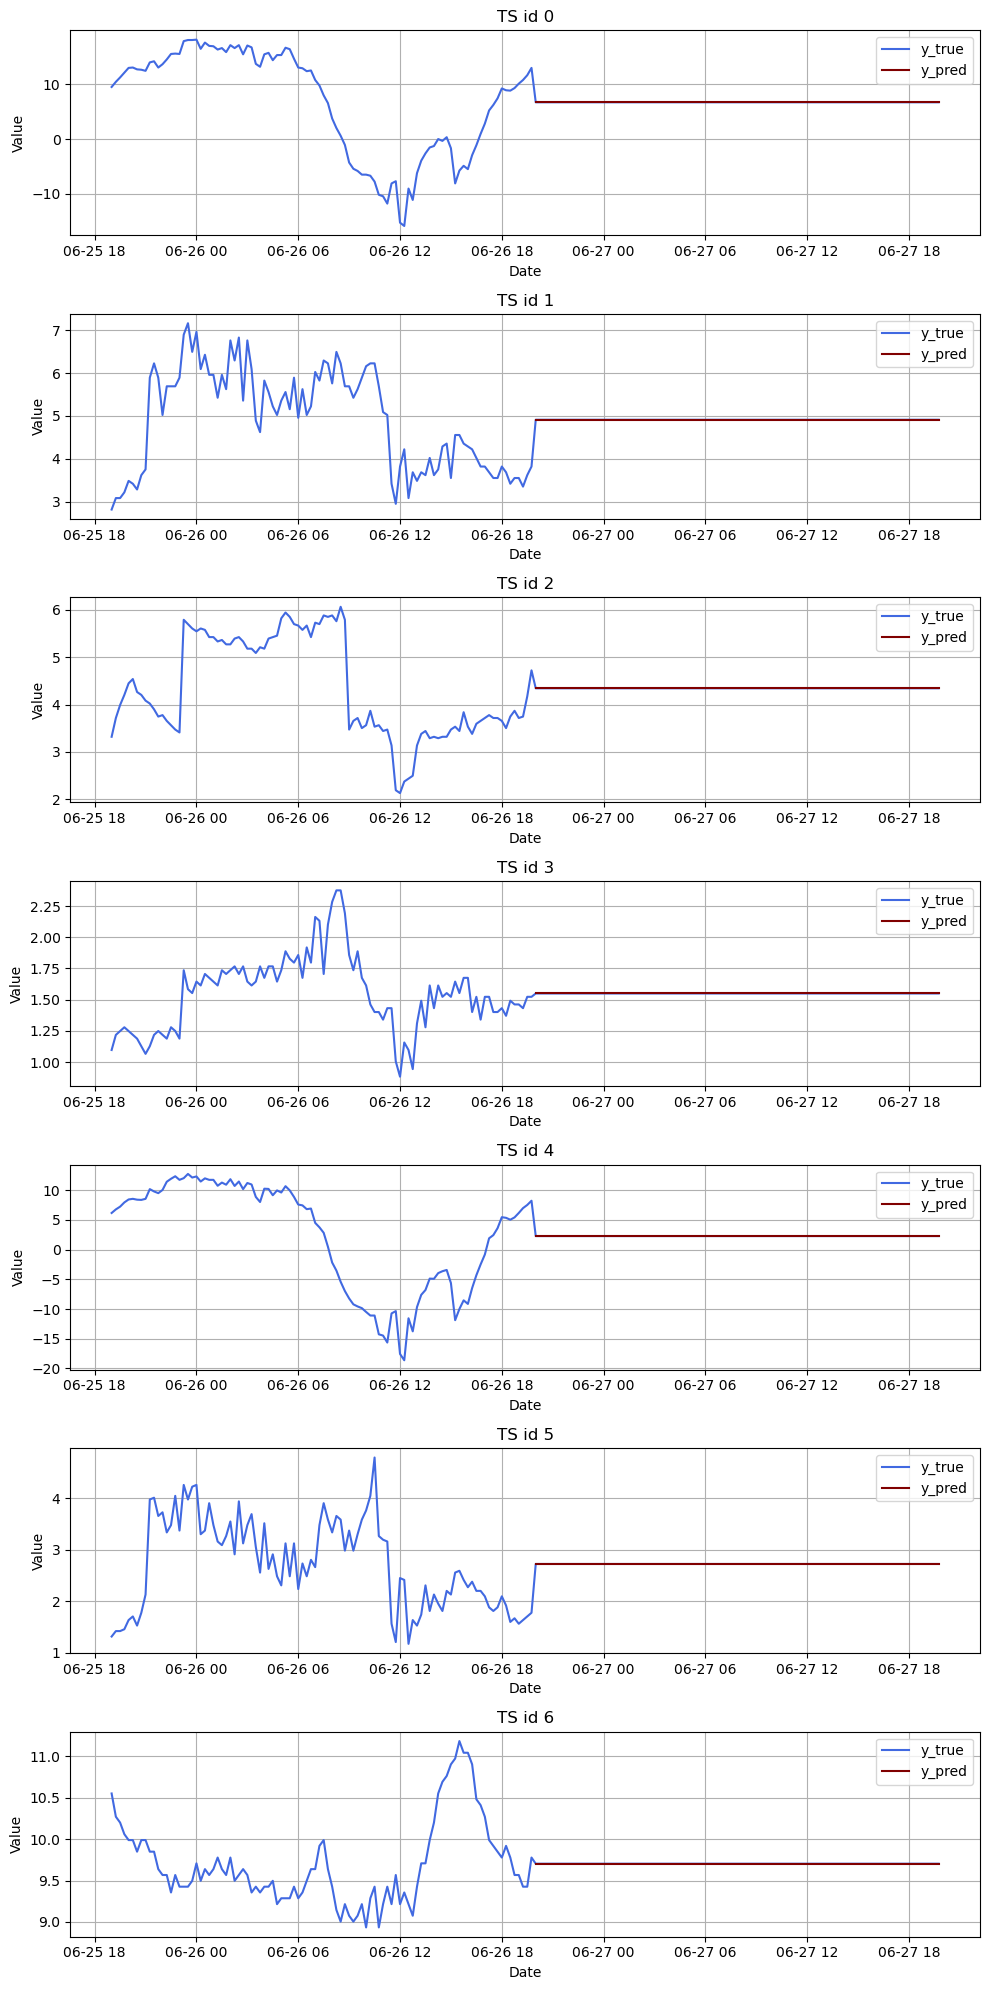

In [5]:
MM = MeanMethod(baseline_df)
preds_mm = MM.predict()

plot_baseline_results(preds_mm, horizon)

### 2. Naive method

Naive method entails predicting that all future values will be the same, specifically equal to the historical last kwown value.

$$\hat{y}_{T+h|T} = y_{T}$$

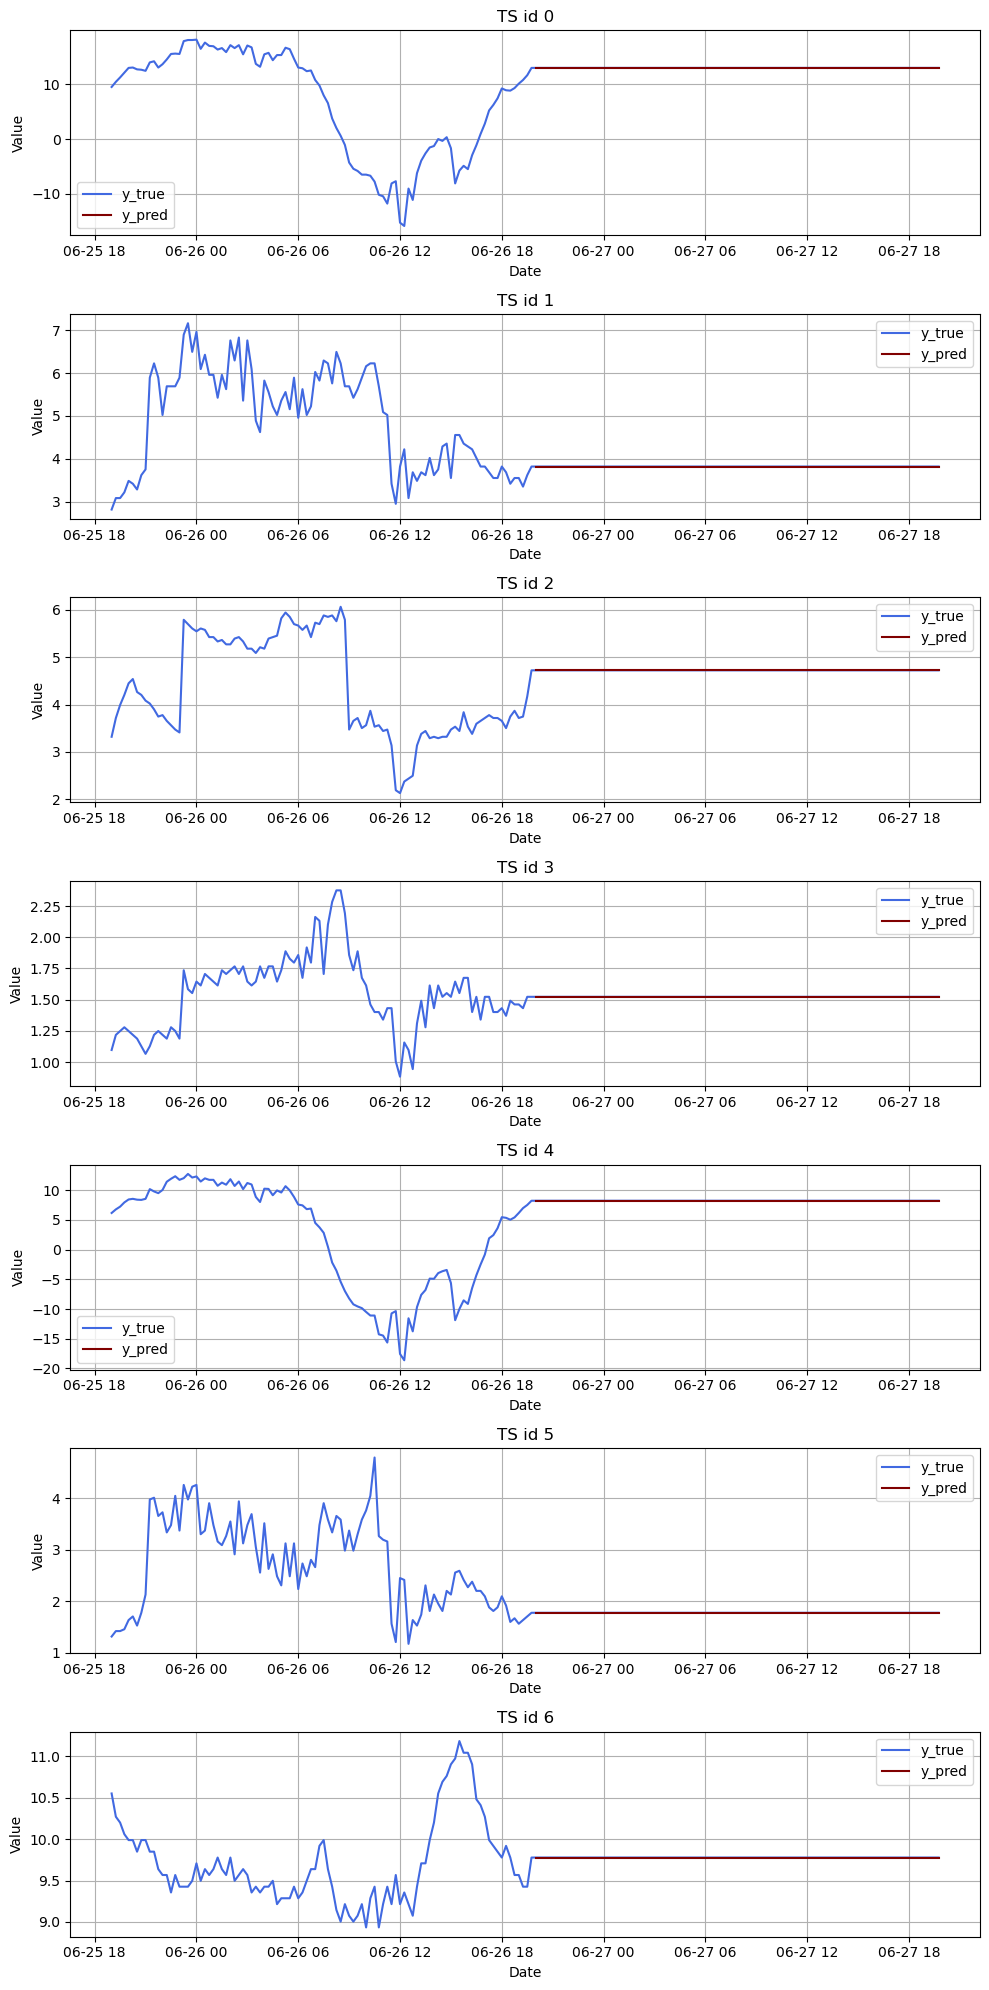

In [6]:
NM = NaiveMethod(baseline_df)
preds_nm = NM.predict()

plot_baseline_results(preds_nm, horizon)

### 3. Seasonal naive method

Predicts future values based on the values from the corresponding season in the previous cycle.

$$\hat{y}_{T+h|T} = y_{T+h-m(k+1)}$$

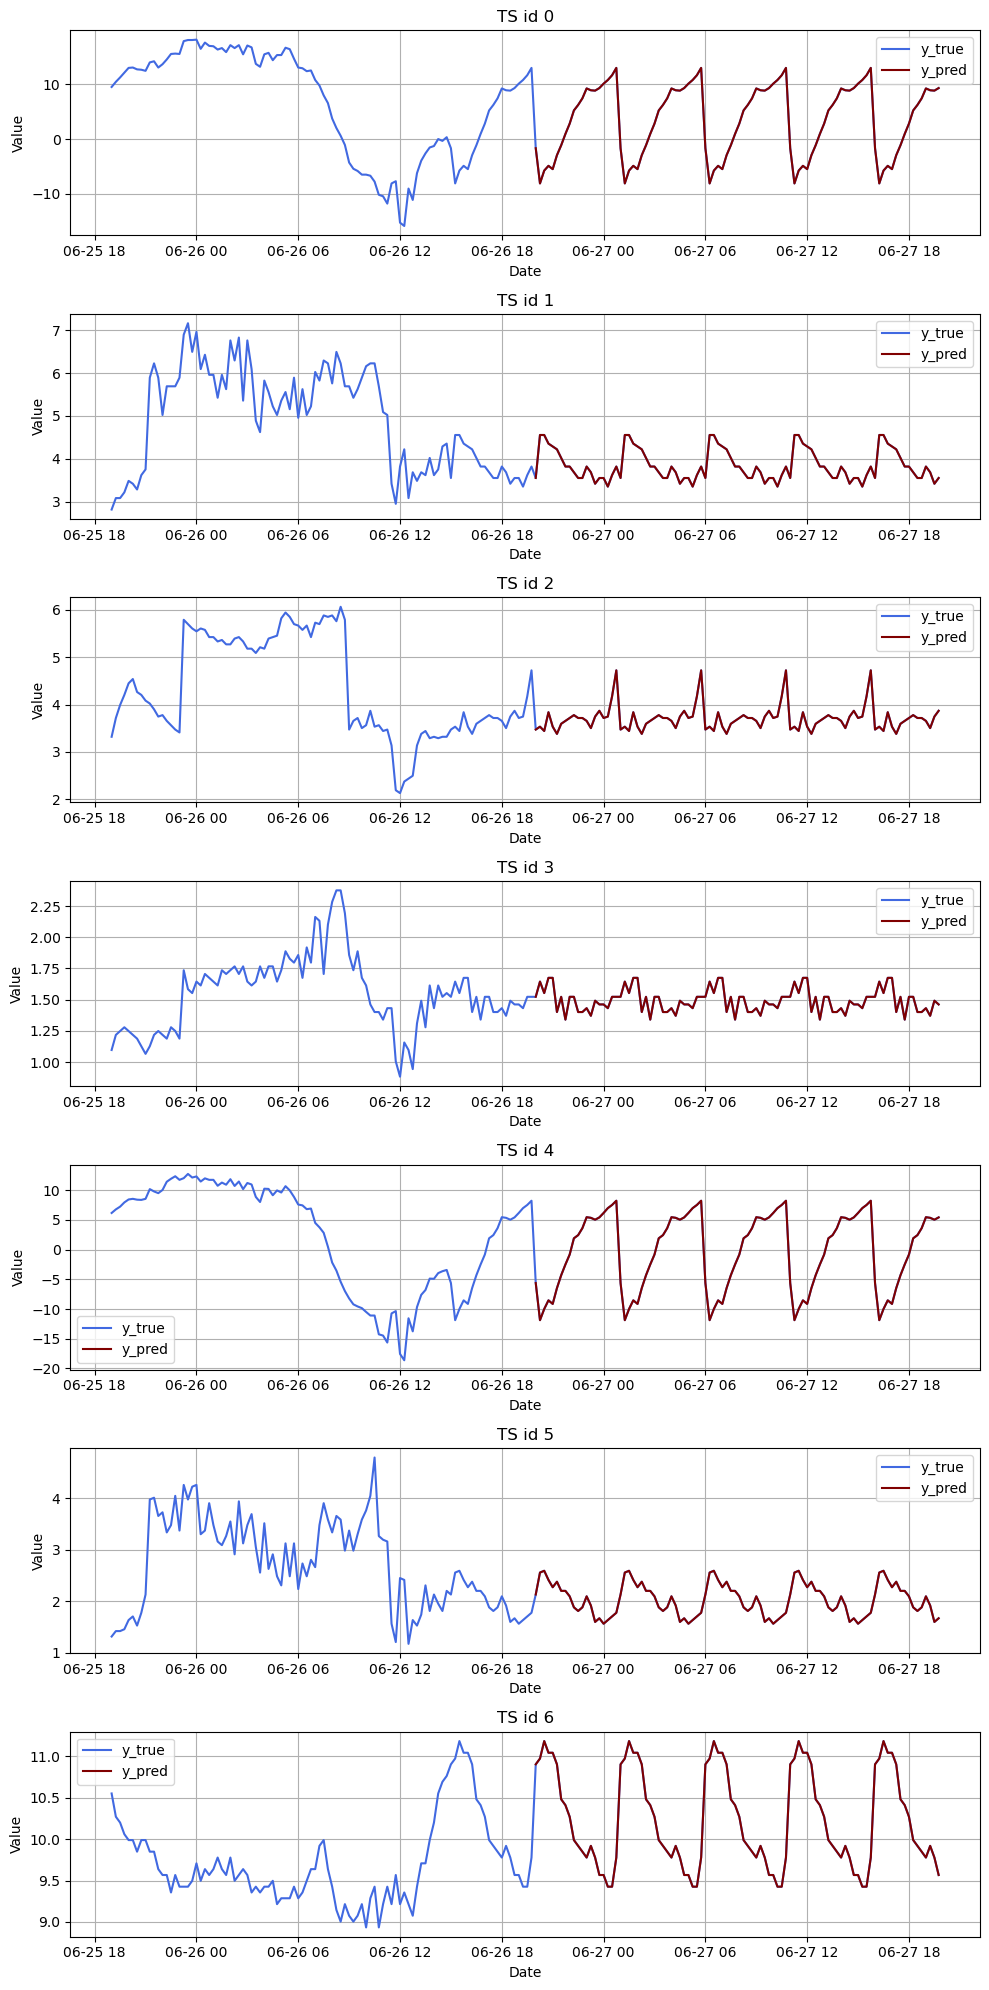

In [7]:
SNM = SeasonalNaiveMethod(baseline_df, 20) # 20 points = season cycle
preds_snm = SNM.predict()

plot_baseline_results(preds_snm, horizon)

### 4. Drift method

A variation on the naive method is to allow the forecasts to increase or decrease over time, where the amount of change over time (called the drift) is set to be the average change seen in the historical data.

$$\hat{y}_{T+h|T} = y_{T} + \frac{h}{T-1}\sum_{t=2}^T (y_{t}-y_{t-1}) = y_{T} + h \left( \frac{y_{T} -y_{1}}{T-1}\right)$$

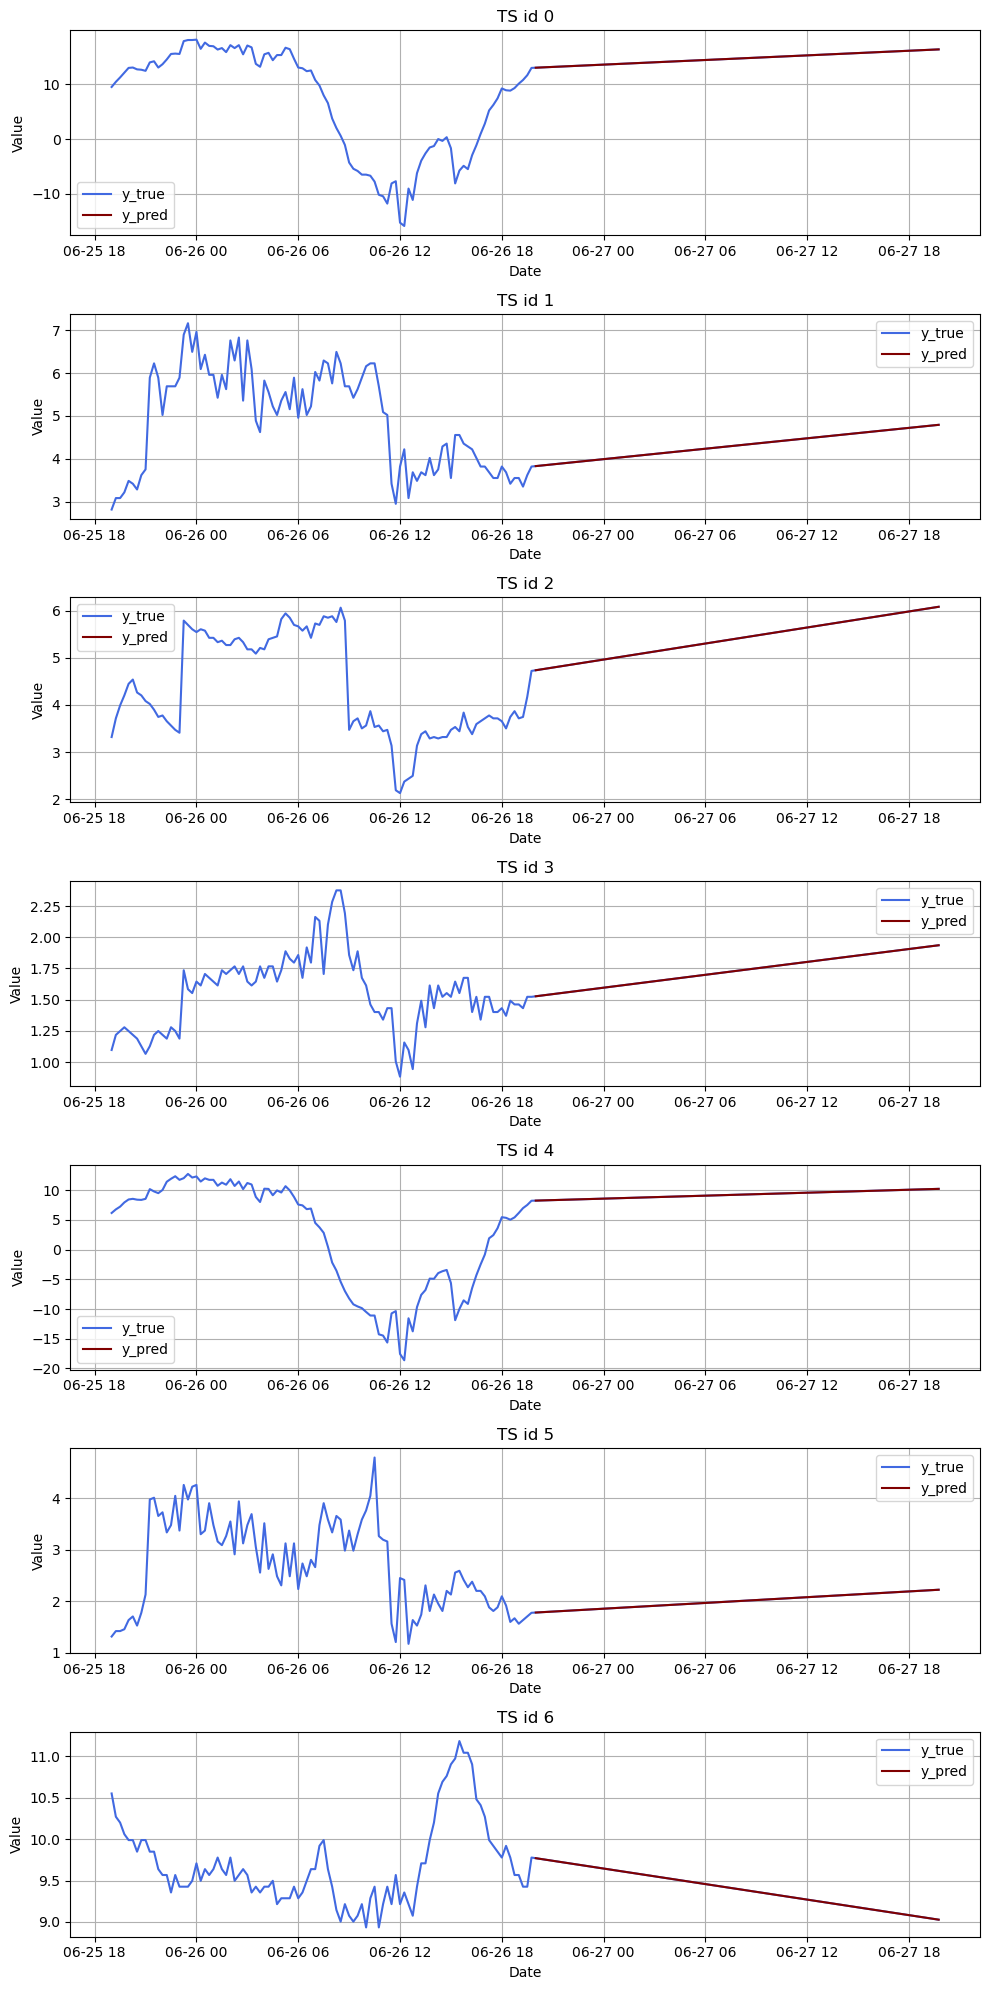

In [8]:
DRIFT = DriftMethod(baseline_df)
preds_drift = DRIFT.predict()

plot_baseline_results(preds_drift, horizon)

## Statistical models  

In this section, we will review 3 statistical models taken from the [StatsForecast library by Nixtla](https://nixtlaverse.nixtla.io/statsforecast/index.html). It was decided to use the implementations from Nixtla specifically because they work faster and have the familiar methods .fit() and .predict(), unlike the models from the statmodels library.

### 1. AutoETS model

In [9]:
ets_params = {
    'model': ['A', 'N', 'N'],
    'season_length': 1,
    'damped': None,
    'phi': None
}

ets_strategy_params = {
    "is_multivariate": False, 
    "strategy_name": "StatModels",
    "strategy_params": {
        "horizon": 96,
        "model_name": "ETS_Model",
        "validation_params": None,
        "model_params": ets_params,
        "k": 1,
    }
}

In [10]:
strategy_ets = strategies_factory[ets_strategy_params]

In [11]:
ids, test, pred, fit_time, forecast_time, num_iterations = strategy_ets.back_test(dataset, cv=1)

freq: less then Day (Hour, Min, Sec, etc); period: 900.0 seconds


In [12]:
ets_results = get_results(cv=1, regime="global", y_true=test, y_pred=pred, ids=ids)
ets_results

,y_true_1,y_pred_1,id_1
0,12.994,10.060014,0
1,13.061,10.060014,0
2,12.726,10.060014,0
3,12.659,10.060014,0
4,12.458,10.060014,0
...,...,...,...
667,9.567,10.060014,6
668,9.567,10.060014,6
669,9.426,10.060014,6
670,9.426,10.060014,6


### 2. AutoARIMA model

In [13]:
autoarima_params = {
    'd': None,
    'D': None,
    'max_p': 5,
    'max_q': 5,
    'max_P': 2,
    'max_Q': 2,
    'max_order': 5,
    'max_d': 2,
    'max_D': 1,
    'start_p': 2,
    'start_q': 2,
    'start_P': 1,
    'start_Q': 1,
    'stationary': False,
    'seasonal': True,
    'season_length': 1,
}

autoarima_strategy_params = {
    "is_multivariate": False, 
    "strategy_name": "StatModels",
    "strategy_params": {
        "horizon": 96,
        "model_name": "AutoARIMA_Model",
        "model_params": autoarima_params,
        "validation_params": None,
        "k": 1,
    }
}

In [14]:
strategy_arima = strategies_factory[autoarima_strategy_params]

In [15]:
ids, test, pred, fit_time, forecast_time, num_iterations = strategy_arima.back_test(dataset, cv=1)

freq: less then Day (Hour, Min, Sec, etc); period: 900.0 seconds


In [16]:
arima_results = get_results(cv=1, regime="global", y_true=test, y_pred=pred, ids=ids)
arima_results

,y_true_1,y_pred_1,id_1
0,12.994,10.056074,0
1,13.061,10.063438,0
2,12.726,10.067070,0
3,12.659,10.068252,0
4,12.458,10.068557,0
...,...,...,...
667,9.567,10.068626,6
668,9.567,10.068626,6
669,9.426,10.068626,6
670,9.426,10.068626,6


### 3. AutoTheta model

__Warning:__ If each time series contains more than 30,000 observations, the model will take a very long time to train. In our case, each TS contains almost 70,000 observations.

In [17]:
theta_params = {
    'season_length': 1, 
}

autotheta_strategy_params = {
    "is_multivariate": False, 
    "strategy_name": "StatModels",
    "strategy_params": {
        "horizon": 96,
        "model_name": "AutoTheta_Model",
        "model_params": theta_params,
        "validation_params": None,
        "k": 1,
    }
}

In [18]:
strategy_theta = strategies_factory[autotheta_strategy_params]

In [19]:
%%time
ids, test, pred, fit_time, forecast_time, num_iterations = strategy_theta.back_test(dataset, cv=1)

freq: less then Day (Hour, Min, Sec, etc); period: 900.0 seconds
Model 1 has been fitted!
Model 2 has been fitted!
Model 3 has been fitted!
Model 4 has been fitted!
Model 5 has been fitted!
Model 6 has been fitted!
Model 7 has been fitted!
CPU times: total: 45min 36s
Wall time: 3h 6min 9s


In [20]:
theta_results = get_results(cv=1, regime="global", y_true=test, y_pred=pred, ids=ids)
theta_results

,y_true_1,y_pred_1,id_1
0,12.994,10.061364,0
1,13.061,10.061320,0
2,12.726,10.061276,0
3,12.659,10.061233,0
4,12.458,10.061189,0
...,...,...,...
667,9.567,10.057372,6
668,9.567,10.057328,6
669,9.426,10.057284,6
670,9.426,10.057240,6


In [21]:
dataframes_with_names = [(ets_results, "AutoETS"), (arima_results, "AutoARIMA"), (theta_results, "AutoTheta")]
calculate_score(dataframes_with_names)

,Model,id,MAE,MSE,RMSE,SMAPE,WAPE
0,AutoETS,0,8.406427,108.885221,10.434808,95.230459,80.137290
1,AutoETS,1,5.070775,27.010464,5.197159,68.944277,101.634223
2,AutoETS,2,5.695202,33.565204,5.793548,80.490454,130.479876
3,AutoETS,3,8.496150,72.271516,8.501266,146.405735,543.279130
4,AutoETS,4,8.654538,147.848043,12.159278,95.652204,99.121529
5,AutoETS,5,7.278671,53.701871,7.328156,114.741724,261.696192
6,AutoETS,6,0.560208,0.392281,0.626323,5.698542,5.787309
7,AutoARIMA,0,8.406453,108.947105,10.437773,95.201610,80.137540
8,AutoARIMA,1,5.079181,27.095154,5.205301,69.017203,101.802703
9,AutoARIMA,2,5.703608,33.661058,5.801815,80.559488,130.672459
